In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc; gc.enable()
from sklearn import preprocessing, linear_model, metrics
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



In [3]:
dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
data = {
    'tra': pd.read_csv('../input/train.csv', dtype=dtypes, parse_dates=['date']),
    #'tes': pd.read_csv('../input/test.csv', dtype=dtypes, parse_dates=['date']),
    'ite': pd.read_csv('../input/items.csv'),
    #'sto': pd.read_csv('../input/stores.csv'),
    #'trn': pd.read_csv('../input/transactions.csv', parse_dates=['date']),
    #'hol': pd.read_csv('../input/holidays_events.csv', dtype={'transferred':str}, parse_dates=['date']),
    #'oil': pd.read_csv('../input/oil.csv', parse_dates=['date']),
    }

In [4]:
train = data['tra']#[(data['tra']['date'].dt.month == 8) & (data['tra']['date'].dt.day > 15)]
#test = data['tes']#[(data['tes']['date'].dt.month == 8) & (data['test']['date'].dt.day > 15)]
train["item_nbr"].value_counts(sort = True,ascending=False).nlargest(5)

502331    83475
314384    83450
364606    83308
265559    83047
559870    82513
Name: item_nbr, dtype: int64

In [5]:
strain_502331= train[(train["item_nbr"] == 502331)]
#stest_502331= test[(test["item_nbr"] == 502331)]
strain = strain_502331
#stest = stest_502331

print(strain.shape)

target = strain['unit_sales'].values
target[target < 0.] = 0.
strain['unit_sales'] = target

strain = pd.merge(strain, data['ite'], how='left', on=['item_nbr'])
#strain = pd.merge(strain, data['sto'], how='left', on=['store_nbr'])
#data_h_1 = data['hol'][data['hol']['locale'] == 'National'][['date','transferred']]
#data_h_1['transferred'] = data_h_1['transferred'].map({'False': 0, 'True': 1})
#strain = pd.merge(strain, data_h_1, how='left', on=['date'])
#strain = pd.merge(strain, data['oil'], how='left', on=['date'])


(83475, 6)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [6]:
from sklearn import preprocessing
def df_transform(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['onpromotion'] = df['onpromotion'].map({'False': 1, 'True': 2})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    df = df.fillna(0)
    return df
def df_lbl_enc(df):
    for c in df.columns:
        if df[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            df[c] = lbl.fit_transform(df[c])
            print(c)
    return df

In [7]:
strain_t = df_transform(strain)
strain_t_e = df_lbl_enc(strain_t)

family


In [8]:
df = strain_t_e.set_index('date')

In [9]:
train, test =df['2013':'2016'], df['2017']
train=train[['unit_sales']]
test=(test[['unit_sales']])

In [10]:
import numpy
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
look_back = 7
trainX, trainY = create_dataset(train.values, look_back)
testX, testY = create_dataset(test.values, look_back)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
import time
t_s = time.time()
history = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=10, batch_size=3, verbose=2)
t_e = time.time()

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Train on 71389 samples, validate on 12070 samples
Epoch 1/10
 - 76s - loss: 1011.0045 - acc: 0.0138 - val_loss: 597.3515 - val_acc: 0.0146
Epoch 2/10
 - 76s - loss: 885.1764 - acc: 0.0155 - val_loss: 423.5192 - val_acc: 0.0196
Epoch 3/10
 - 76s - loss: 729.3315 - acc: 0.0180 - val_loss: 415.4885 - val_acc: 0.0200
Epoch 4/10
 - 76s - loss: 714.3581 - acc: 0.0180 - val_loss: 406.3492 - val_acc: 0.0222
Epoch 5/10
 - 74s - loss: 700.1131 - acc: 0.0180 - val_loss: 401.5412 - val_acc: 0.0213
Epoch 6/10
 - 81s - loss: 692.4641 - acc: 0.0191 - val_loss: 414.2574 - val_acc: 0.0202
Epoch 7/10
 - 77s - loss: 688.9993 - acc: 0.0187 - val_loss: 396.6306 - val_acc: 0.0214
Epoch 8/10
 - 75s - loss: 689.6457 - acc: 0.0187 - val_loss: 467.0162 - val_acc: 0.0189
Epoch 9/10
 - 74s - loss: 697.1177 - acc: 0.0176 - val_loss: 463.7588 - val_acc: 0.0183
Epoch 10/10
 - 76s - loss: 697.3289 - acc: 0.0180 - val_loss: 413.8254 - val_acc: 0.0200


12.677727138996124
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


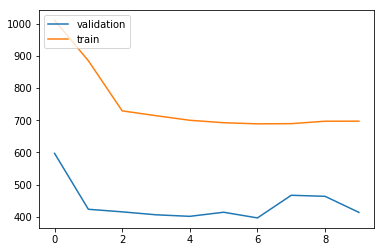

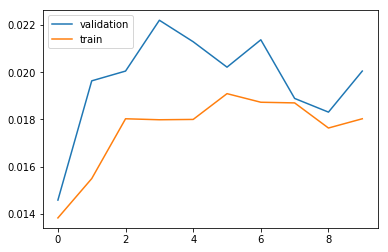

In [14]:
t = t_e-t_s
print(t/60)
print(history.history.keys())
plt.plot(history.history['val_loss'],label='validation')
plt.plot(history.history['loss'], label='train')
plt.legend(loc='upper left')
plt.show()
plt.plot(history.history['val_acc'],label='validation')
plt.plot(history.history['acc'], label='train')
plt.legend(loc='upper left')
plt.show()

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting

testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict


NWRMSLE LSTM 0.613153733822


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


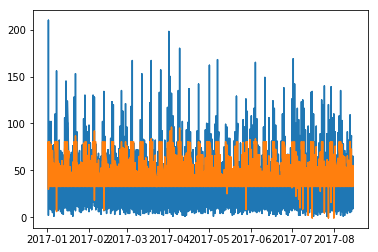

In [16]:
df['2017']['perishable'] = 1.25
W_test = df['2017']['perishable']

W_test = numpy.empty_like(testY)
W_test[:] = 1.25

from sklearn import metrics
def NWRMSLE(y, pred, w):
    return metrics.mean_squared_error(y, pred, sample_weight=w)**0.5
print('NWRMSLE LSTM',NWRMSLE(np.log1p(testY),np.log1p(testPredict),W_test))

dfp = test.tail(-8)
dfp = dfp.shift(1)
dfp['pred'] = testY
dfp['pred'] = testPredict
#dfp['2017-01-02'].unit_sales = 57.0
dfp.head()

plt.plot(dfp['unit_sales'])
plt.plot(dfp['pred'])
plt.show()
